In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import deeplenstronomy.deeplenstronomy as dl
from deeplenstronomy.visualize import view_image, view_image_rgb

import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import configparser
import psycopg2
import re
from datetime import datetime
import scipy
import random
import photutils
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, sigma_clip
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer
import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [25]:
def vis_random_dist(data, vmin = 0, vmax = 10, seed = None,):
    fig, axs = plt.subplots(2, 4, figsize=(10, 5))

    if seed is not None:
        np.random.seed(seed)
    
    # Generate random i values between 1 and 100
    i_values = np.random.randint(1, 101, size=(4, 4))
    normalizer = Normalize(vmin = vmin, vmax = vmax)
    im = cm.ScalarMappable(norm = normalizer)
    for i in range(2):
        for j in range(4):
            title = axs[i, j].set_title("i = " + str(i_values[i, j]))
            k = axs[i, j].imshow(data[i_values[i, j]], norm = normalizer)
            axoff = axs[i, j].axis('off')

    a = plt.tight_layout()
    a = plt.colorbar(im, ax=axs.ravel().tolist())
    return fig, axs

def get_random_dist(data):
    # Set the random seed for reproducibility
    np.random.seed(0)

    # Generate random i values between 1 and 100
    i_values = np.random.randint(1, 101, size=(4, 4))

    # Create a 4x4 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    # Iterate over the subplots and plot the histograms
    for i in range(4):
        for j in range(4):
            # Get the normalized_source for the current i value
            normalized_source_i = data[i_values[i, j]]
            
            # Plot the histogram
            a = axs[i, j].hist(normalized_source_i.flatten(), bins=20, color='blue', alpha=0.7)
            b = axs[i, j].set_title(f'i = {i_values[i, j]}')
            c = axs[i, j].set_xlabel('Normalized Target')
            d = axs[i, j].set_ylabel('Frequency')

    # Adjust the spacing between subplots
    plt.tight_layout()

    return fig, axs

In [3]:
source = np.load('pax_source/CONFIGURATION_1_images.npy')[:, 0, :, :]
src_md = pd.read_csv('pax_source/CONFIGURATION_1_metadata.csv')
target = np.load('pax_target/CONFIGURATION_1_images.npy')[:, 0, :, :]
target_md = pd.read_csv('pax_target/CONFIGURATION_1_metadata.csv')

In [4]:
target_md.columns

Index(['OBJID-g', 'H0-g', 'Om0-g', 'exposure_time-g', 'numPix-g',
       'pixel_scale-g', 'psf_type-g', 'read_noise-g', 'ccd_gain-g', 'seeing-g',
       'magnitude_zero_point-g', 'sky_brightness-g', 'num_exposures-g',
       'NUMBER_OF_NOISE_SOURCES-g', 'CONFIGURATION_LABEL-g',
       'CONFIGURATION_NAME-g', 'NUMBER_OF_PLANES-g',
       'PLANE_1-NUMBER_OF_OBJECTS-g', 'PLANE_1-OBJECT_1-NAME-g',
       'PLANE_2-NUMBER_OF_OBJECTS-g', 'PLANE_2-OBJECT_1-NAME-g',
       'PLANE_1-OBJECT_1-REDSHIFT-g',
       'PLANE_1-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g',
       'PLANE_1-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g',
       'PLANE_1-OBJECT_1-NUMBER_OF_MASS_PROFILES-g', 'PLANE_1-OBJECT_1-HOST-g',
       'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-NAME-g',
       'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
       'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_x-g',
       'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_y-g',
       'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
       'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_se

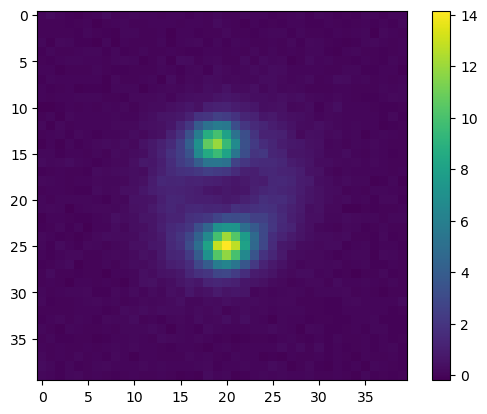

In [12]:
plt.imshow(source[57])
plt.colorbar()

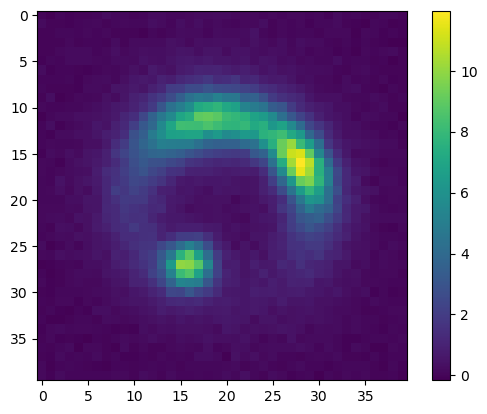

In [10]:
plt.imshow(target[62])
plt.colorbar()

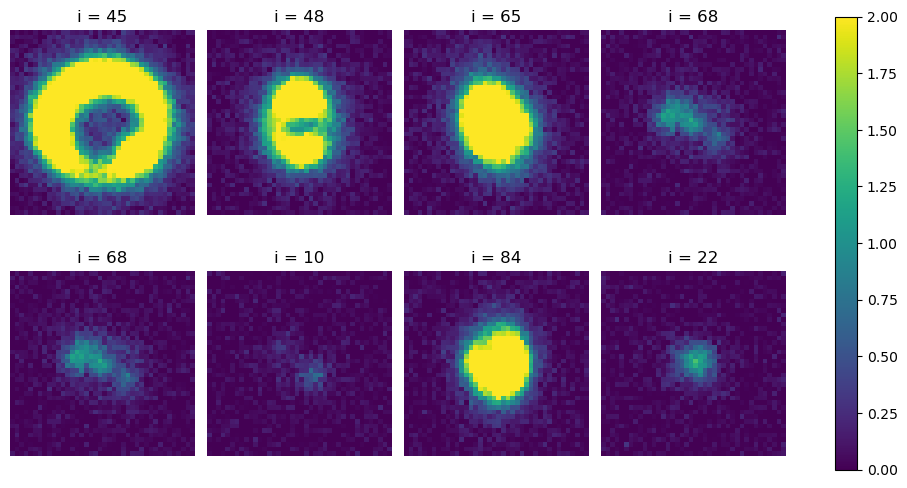

In [26]:
fig, axs = vis_random_dist(source, vmin = 0, vmax = 2, seed = 0)


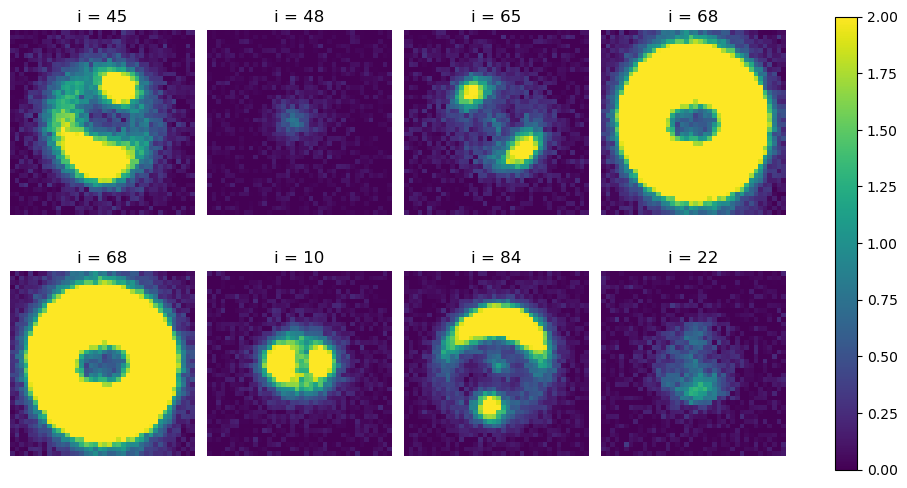

In [27]:
fig, axs = vis_random_dist(target, vmin = 0, vmax = 2, seed = 0)


In [21]:
def get_clipped_stats(data, sigma):
    scs = sigma_clipped_stats(data, sigma=sigma, axis = (1, 2))
    return scs

source_clipped_stats = get_clipped_stats(source, 2)[1] # mean, MEDIAN, std
target_clipped_stats = get_clipped_stats(target, 2)[1] # mean, MEDIAN, std

In [22]:
clipped_source = (source - source_clipped_stats[:, np.newaxis, np.newaxis])
clipped_target = (target - target_clipped_stats[:, np.newaxis, np.newaxis])

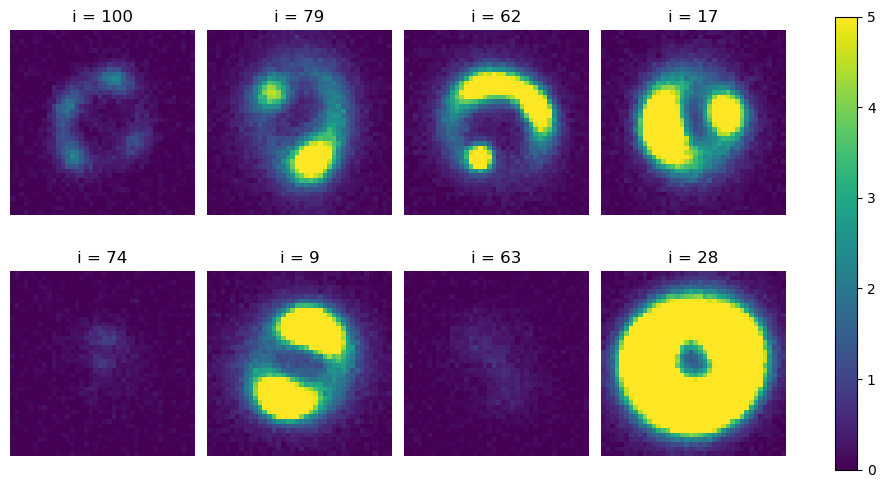

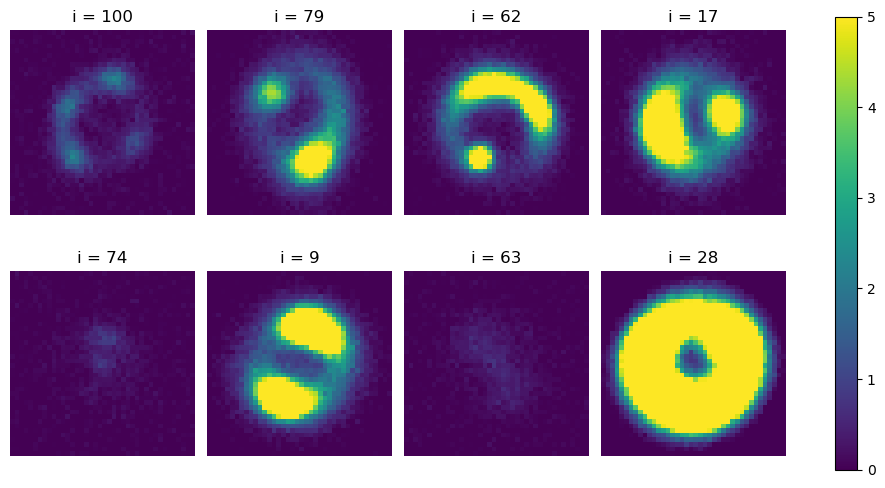

In [28]:
fig, axs = vis_random_dist(target, vmin = 0, vmax = 5, seed = 5)
fig, axs = vis_random_dist(clipped_target, vmin = 0, vmax = 5, seed = 5)

In [38]:
def normalize(data):
    log_data = np.log1p(data)
    scaler = RobustScaler()
    normalized_data = scaler.fit_transform(log_data.reshape(-1, 1)).reshape(data.shape)
    return normalized_data

In [39]:
normalized_source = normalize(source)
normalized_target = normalize(target)
normalized_clipped_target = normalize(clipped_target)

(<Figure size 1000x500 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'i = 25'}>,
         <AxesSubplot:title={'center':'i = 4'}>,
         <AxesSubplot:title={'center':'i = 57'}>,
         <AxesSubplot:title={'center':'i = 73'}>],
        [<AxesSubplot:title={'center':'i = 1'}>,
         <AxesSubplot:title={'center':'i = 22'}>,
         <AxesSubplot:title={'center':'i = 20'}>,
         <AxesSubplot:title={'center':'i = 75'}>]], dtype=object))

(<Figure size 1000x500 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'i = 25'}>,
         <AxesSubplot:title={'center':'i = 4'}>,
         <AxesSubplot:title={'center':'i = 57'}>,
         <AxesSubplot:title={'center':'i = 73'}>],
        [<AxesSubplot:title={'center':'i = 1'}>,
         <AxesSubplot:title={'center':'i = 22'}>,
         <AxesSubplot:title={'center':'i = 20'}>,
         <AxesSubplot:title={'center':'i = 75'}>]], dtype=object))

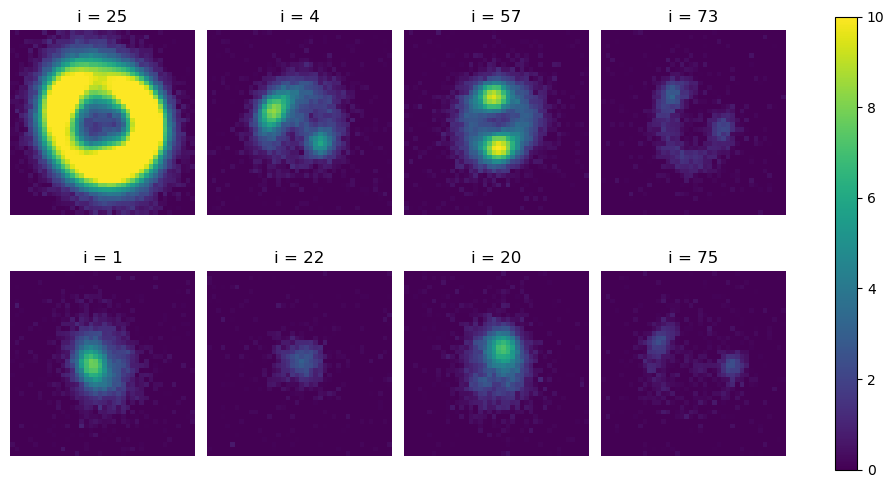

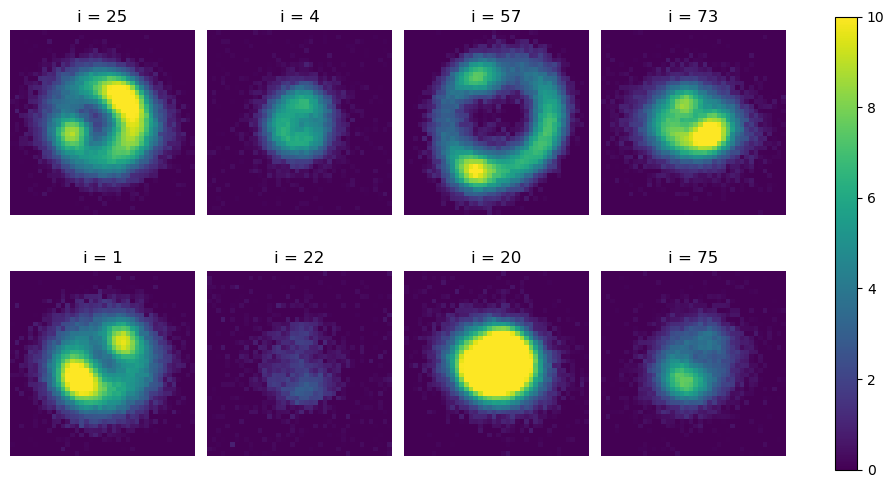

In [43]:
vis_random_dist(normalized_source, seed = 3)
vis_random_dist(normalized_clipped_target, seed = 3)

(array([  2.,   9.,  30., 104., 225., 349., 332., 249., 118.,  57.,  26.,
         30.,  13.,  10.,  15.,  11.,  11.,   5.,   0.,   4.]),
 array([-1.46189589, -1.2641616 , -1.06642732, -0.86869304, -0.67095875,
        -0.47322447, -0.27549018, -0.0777559 ,  0.11997838,  0.31771267,
         0.51544695,  0.71318123,  0.91091552,  1.1086498 ,  1.30638408,
         1.50411837,  1.70185265,  1.89958694,  2.09732122,  2.2950555 ,
         2.49278979]),
 <BarContainer object of 20 artists>)

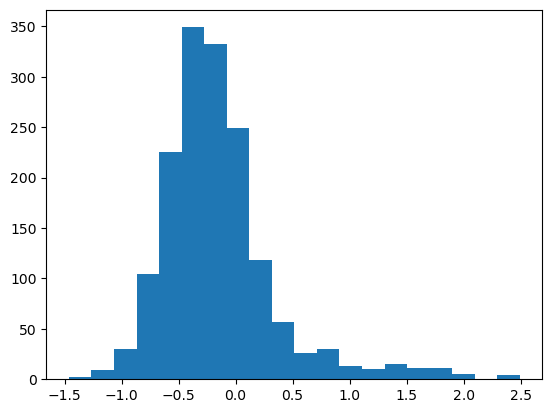

In [49]:
plt.hist(normalized_source[5].flatten(), bins = 20)

(array([  1.,   5.,  36., 127., 305., 378., 324., 178.,  85.,  52.,  20.,
         19.,  15.,  11.,  11.,  12.,   8.,   8.,   2.,   3.]),
 array([-1.44327286, -1.21956177, -0.99585069, -0.7721396 , -0.54842852,
        -0.32471743, -0.10100635,  0.12270474,  0.34641582,  0.57012691,
         0.79383799,  1.01754908,  1.24126016,  1.46497125,  1.68868233,
         1.91239342,  2.1361045 ,  2.35981559,  2.58352667,  2.80723776,
         3.03094884]),
 <BarContainer object of 20 artists>)

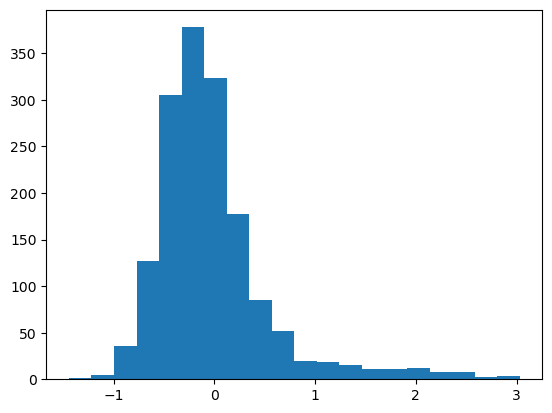

In [57]:
plt.hist(normalized_target[6].flatten(), bins = 20)

In [58]:
np.save('pax_source/paxnorm_source.npy', normalized_source)
np.save('pax_target/paxnorm_target.npy', normalized_target)

(array([146., 724., 236.,  80.,  51.,  48.,  28.,  24.,  28.,  17.,  20.,
         19.,   9.,  21.,  23.,  23.,  35.,  24.,  26.,  18.]),
 array([-1.30574646, -0.53432166,  0.23710313,  1.00852793,  1.77995272,
         2.55137752,  3.32280231,  4.09422711,  4.86565191,  5.6370767 ,
         6.4085015 ,  7.17992629,  7.95135109,  8.72277588,  9.49420068,
        10.26562547, 11.03705027, 11.80847506, 12.57989986, 13.35132465,
        14.12274945]),
 <BarContainer object of 20 artists>)

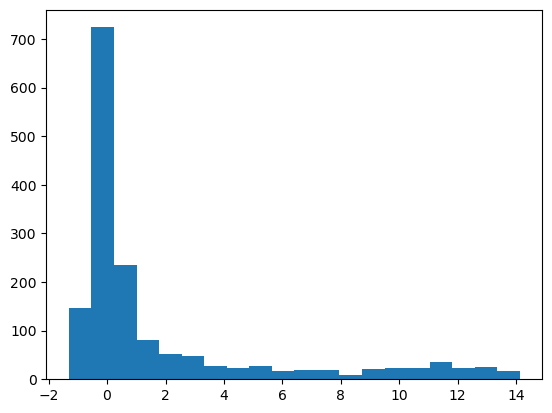

In [64]:
plt.hist(normalized_target[20].flatten(), bins = 20)

(array([1321.,   59.,   36.,   14.,   19.,   18.,   13.,   14.,   18.,
          14.,   12.,   11.,   10.,   10.,    4.,    9.,    6.,    4.,
           5.,    3.]),
 array([-0.23869085,  2.72525734,  5.68920553,  8.65315371, 11.6171019 ,
        14.58105009, 17.54499828, 20.50894647, 23.47289465, 26.43684284,
        29.40079103, 32.36473922, 35.32868741, 38.29263559, 41.25658378,
        44.22053197, 47.18448016, 50.14842835, 53.11237653, 56.07632472,
        59.04027291]),
 <BarContainer object of 20 artists>)

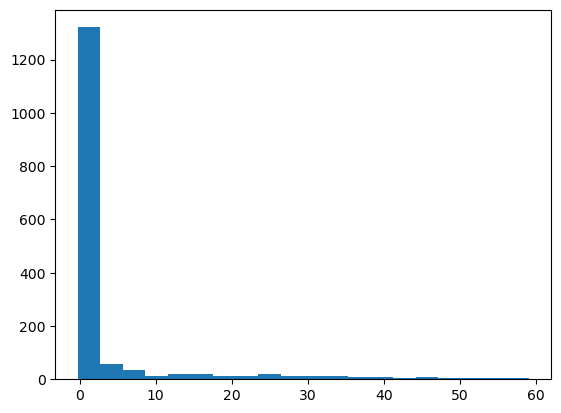

In [62]:
plt.hist(target[20].flatten(), bins = 20)